# Prepare data

In [1]:
!pip install evaluate
!pip install faiss-cpu
!pip install rouge_score
!pip install bert-score
!pip install python-docx
!pip install kaggle-environments==1.14.14
# !pip install sentence-transformers==2.2.2
# !pip install trl==0.7.4
!pip install transformers==4.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b855832462cdcffcfe89dc04a0be08ec2173645b9029ac96347a040823b88462
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 1.14.15
    Uninstalling kaggle-environments-1.14.15:
      Successfully uninstalled kaggle-environments-1.14.15
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

T5TokenizerFast(name_or_path='VietAI/vit5-base', vocab_size=36096, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra

In [ ]:
import asyncio
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
import torch
import os
import faiss
import pandas as pd
import evaluate
import random
import shutil
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.amp import autocast, GradScaler
import re
from docx import Document
import random
from tqdm import tqdm


# Cấu hình thiết bị và biến môi trường cho multi-GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Sử dụng 2 GPU đầu tiên
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def remove_lines_in_chuong_muc(lines, chuong_positions, muc_positions):
    # Tạo danh sách các nội dung trong chuong_positions và muc_positions
    chuong_texts = [text for idx, text in chuong_positions]
    muc_texts = [text for idx, text in muc_positions]
    
    # Lọc các dòng không có nội dung trùng với các chuong_texts hoặc muc_texts
    filtered_lines = [line for line in lines if line.strip() not in chuong_texts and line.strip() not in muc_texts]
    
    return filtered_lines

def extract_content_from_paragraphs(example, file_path, idx_list, chuong_positions, muc_positions):
    # Đọc tài liệu .docx trong mỗi tiến trình
    doc = Document(file_path)
    
    # Tính toán vị trí bắt đầu và kết thúc
    start_idx = example["idx"]
    end_idx = idx_list[idx_list.index(start_idx) + 1] if start_idx < idx_list[-1] else len(doc.paragraphs)

    # Ghép nội dung các đoạn văn
    content = " \n ".join([doc.paragraphs[j].text for j in range(start_idx, end_idx) if doc.paragraphs[j].text.strip()])
    lines = content.split('\n')
    lines = remove_lines_in_chuong_muc(lines, chuong_positions, muc_positions)
    # Khởi tạo các biến kết quả
    input_lines = []
    target_spans = []
    current_extra_id = 0
    # Tạo mask nội dung
    for line in lines:
        words = line.strip().split()
        if not words:  # Kiểm tra dòng trống
            continue
            
        num_words_to_mask = max(1, int(len(words) * 0.25))
        words_to_mask = random.sample(range(len(words)), num_words_to_mask)
        words_to_mask = sorted(words_to_mask)
        
        masked_words = words.copy()
        for idx in words_to_mask:
            original_word = masked_words[idx]
            masked_words[idx] = f"<extra_id_{current_extra_id}>"
            target_spans.append(f"<extra_id_{current_extra_id}> {original_word}")
            current_extra_id += 1
        
        input_lines.append(' '.join(masked_words))
    
    return {
        "input_text": ' \n '.join(input_lines),
        "target_text": ' '.join(target_spans)
    }
    

def process_docx_from_local_path(file_path):
    # Đọc tài liệu .docx
    doc = Document(file_path)
    
    # Lưu các điều và vị trí
    dieu_positions = []
    chuong_positions = []
    muc_positions = []
    is_chuong = False
    for idx, paragraph in enumerate(doc.paragraphs):
        if is_chuong:
            chuong_positions.append((idx, paragraph.text))
            is_chuong = False
        if paragraph.text.startswith("Chương"):
            chuong_positions.append((idx, paragraph.text))
            is_chuong = True
        if paragraph.text.startswith("Mục"):
            muc_positions.append((idx, paragraph.text))
        if paragraph.text.startswith("Điều") and len(paragraph.text.split('.')[0]) < 10:
            dieu_positions.append((idx, paragraph.text))
    # print(chuong_positions)
    # print(muc_positions)
    # Tạo Dataset với các vị trí của điều
    dataset = Dataset.from_dict({
        "idx": [dieu[0] for dieu in dieu_positions],
        "title": [dieu[1] for dieu in dieu_positions],
    })
    
    # Lấy danh sách các chỉ số idx
    idx_list = dataset["idx"]

    # Áp dụng xử lý song song với thanh tiến trình
    dataset = dataset.map(
        lambda example: extract_content_from_paragraphs(example, file_path, idx_list, chuong_positions, muc_positions),
        num_proc=4,
        desc="Processing paragraphs"  # Thêm mô tả cho thanh tiến trình
    )
    return dataset

# dataset = process_docx_from_local_path("/kaggle/input/data-luat-qa/bo-luat-dan-su-2015.docx")
# print(dataset)

local_paths = [
                "/kaggle/input/data-luat-qa/bo-luat-100-2015-QH13.docx",
                "/kaggle/input/data-luat-qa/bo-luat-101-2015-QH13.docx",
                "/kaggle/input/data-luat-qa/bo-luat-45-2019-QH14.docx",
                "/kaggle/input/data-luat-qa/bo-luat-95-2015-QH13.docx",
                "/kaggle/input/data-luat-qa/bo-luat-dan-su-2015.docx",
                ]

# Khởi tạo một dataset rỗng
merged_dataset = None

# Duyệt qua tất cả các tệp trong local_paths
for local_path in local_paths:
    print(f"Processing: {local_path}")
    dataset = process_docx_from_local_path(local_path)
    
    # In dataset để kiểm tra
    print(dataset, '\n')

    # Gộp dataset vào dataset chung
    if merged_dataset is None:
        merged_dataset = dataset
    else:
        merged_dataset = concatenate_datasets([merged_dataset, dataset])

# In kết quả
print("Merged Dataset:", merged_dataset)

Processing: /kaggle/input/data-luat-qa/bo-luat-100-2015-QH13.docx


/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Processing paragraphs (num_proc=4):   0%|          | 0/416 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 416
}) 

Processing: /kaggle/input/data-luat-qa/bo-luat-101-2015-QH13.docx


Processing paragraphs (num_proc=4):   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 498
}) 

Processing: /kaggle/input/data-luat-qa/bo-luat-45-2019-QH14.docx


Processing paragraphs (num_proc=4):   0%|          | 0/220 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 220
}) 

Processing: /kaggle/input/data-luat-qa/bo-luat-95-2015-QH13.docx


Processing paragraphs (num_proc=4):   0%|          | 0/341 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 341
}) 

Processing: /kaggle/input/data-luat-qa/bo-luat-dan-su-2015.docx


Processing paragraphs (num_proc=4):   0%|          | 0/689 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 689
}) 

Merged Dataset: Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 2164
})


In [4]:
# Tách tập train/test
split_dataset = merged_dataset.train_test_split(test_size=0.2, seed=42)

# Chọn một lượng mẫu cụ thể cho train và eval dataset
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# Chuyển đổi dữ liệu thành DataFrame để dễ xử lý
train_df = pd.DataFrame(dataset)
eval_df = pd.DataFrame(eval_dataset)

# Kiểm tra lại số lượng giá trị trống trước khi xử lý
print("Số lượng giá trị trống trong tập huấn luyện:\n", train_df.isnull().sum())
print("Số lượng giá trị trống trong tập kiểm thử:\n", eval_df.isnull().sum())

Số lượng giá trị trống trong tập huấn luyện:
 idx            0
title          0
input_text     0
target_text    0
dtype: int64
Số lượng giá trị trống trong tập kiểm thử:
 idx            0
title          0
input_text     0
target_text    0
dtype: int64


In [5]:
train_dataset

Dataset({
    features: ['idx', 'title', 'input_text', 'target_text'],
    num_rows: 1731
})

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


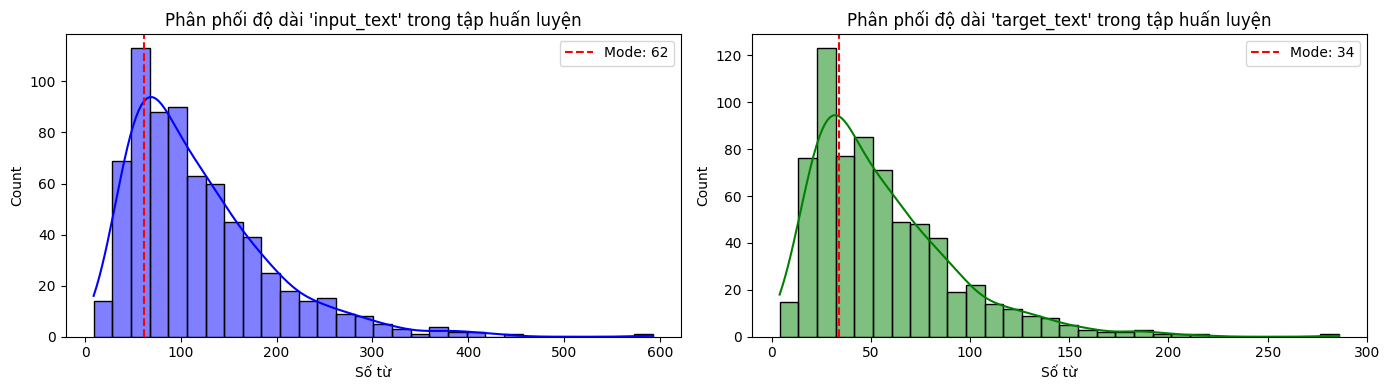

In [6]:
# Tính độ dài của câu hỏi và câu trả lời
train_df['question_length'] = train_df['input_text'].apply(lambda x: len(x.split()) if x is not None else 0)
train_df['answer_length'] = train_df['target_text'].apply(lambda x: len(x.split()) if x is not None else 0)

# Tính giá trị mode (giá trị có tần suất cao nhất)
question_mode = train_df['question_length'].mode()[0]
answer_mode = train_df['answer_length'].mode()[0]

# Vẽ biểu đồ
plt.figure(figsize=(14, 4))

# Biểu đồ phân phối độ dài câu hỏi
plt.subplot(1, 2, 1)
sns.histplot(train_df['question_length'], kde=True, color="blue", bins=30)
plt.title("Phân phối độ dài 'input_text' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(question_mode, color='red', linestyle='--', label=f'Mode: {question_mode}')
plt.legend()

# Biểu đồ phân phối độ dài câu trả lời
plt.subplot(1, 2, 2)
sns.histplot(train_df['answer_length'], kde=True, color="green", bins=30)
plt.title("Phân phối độ dài 'target_text' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(answer_mode, color='red', linestyle='--', label=f'Mode: {answer_mode}')
plt.legend()

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()

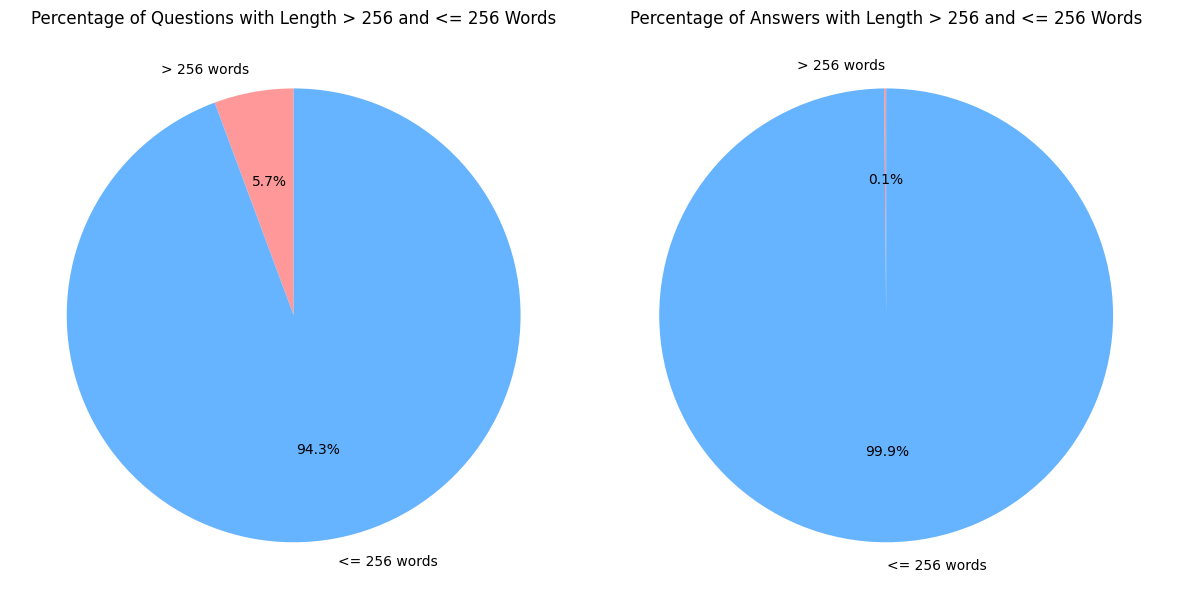

In [7]:
# Thay đổi ngưỡng nếu cần
threshold = 256

# # Tính tổng độ dài của question_length và querie_length
# train_df['combined_question_length'] = train_df['question_length']

# Đếm số lượng câu hỏi có độ dài lớn hơn ngưỡng
num_questions_over_threshold = train_df['question_length'].gt(threshold).sum()

# Đếm số lượng câu trả lời có độ dài lớn hơn ngưỡng
num_answers_over_threshold = train_df['answer_length'].gt(threshold).sum()

# Đếm tổng số câu hỏi và câu trả lời
total_questions = len(train_df)
total_answers = len(train_df['target_text'])

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài lớn hơn ngưỡng
percentage_questions_over_threshold = (num_questions_over_threshold / total_questions) * 100
percentage_answers_over_threshold = (num_answers_over_threshold / total_answers) * 100

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài nhỏ hơn hoặc bằng ngưỡng
percentage_questions_under_threshold = 100 - percentage_questions_over_threshold
percentage_answers_under_threshold = 100 - percentage_answers_over_threshold

# Dữ liệu cho biểu đồ hình tròn
question_data = [percentage_questions_over_threshold, percentage_questions_under_threshold]
answer_data = [percentage_answers_over_threshold, percentage_answers_under_threshold]

# Tạo biểu đồ hình tròn cho câu hỏi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(question_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Questions with Length > {threshold} and <= {threshold} Words')

# Tạo biểu đồ hình tròn cho câu trả lời
plt.subplot(1, 2, 2)
plt.pie(answer_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Answers with Length > {threshold} and <= {threshold} Words')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [8]:
# Khởi tạo model và tokenizer với 'mt5-base'
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Chuyển DataFrame thành dataset của Hugging Face
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

input_encodings = tokenizer(train_dataset[4]['input_text'],
                             truncation=True,
                             padding="max_length",
                             max_length=256)
target_encodings = tokenizer(train_dataset[4]['target_text'], 
                            truncation=True,
                            return_attention_mask=True, 
                            add_special_tokens=True, 
                            padding="max_length", 
                            max_length=256)
print(input_encodings, '\n',target_encodings)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'input_ids': [252, 134, 35792, 1238, 419, 35783, 36095, 1278, 40, 35792, 35783, 36094, 1278, 49, 212, 1971, 35783, 36093, 221, 71, 35783, 36092, 1443, 836, 2118, 35783, 36091, 35783, 36090, 238, 35783, 36089, 1145, 222, 54, 910, 234, 35790, 35783, 36088, 234, 80, 206, 700, 257, 221, 1352, 243, 35790, 74, 401, 240, 35783, 36087, 35783, 36086, 352, 4425, 265, 286, 733, 80, 68, 332, 781, 1018, 35790, 74, 1615, 329, 39, 1270, 419, 1226, 3385, 80, 35783, 36085, 800, 35790, 35783, 36084, 257, 35783, 36083, 1261, 35783, 36082, 257, 1000, 35783, 36081, 35783, 36080, 35783, 36079, 35783, 36078, 508, 257, 221, 35792, 60, 35792, 1401, 373, 72, 790, 129, 71, 13520, 1276, 35783, 36077, 463, 710, 35783, 36076, 212, 35783, 36075, 416, 71, 35783, 36074, 1270, 419, 35783, 36073, 1278, 400, 778, 1278, 1270, 35783, 36072, 129, 74, 35783, 36071, 123, 35783, 36070, 840, 1971, 316, 657, 35783, 36069, 463, 710, 35783, 36068, 221, 35783, 36067, 238, 152, 35783, 36066, 122, 54, 656, 710, 118, 35792, 1, 0, 0, 

In [9]:
# Tiền xử lý dữ liệu
def preprocess_data(example):
    input_text = example["input_text"]
    target_text = example["target_text"]
    
    # Áp dụng padding và truncation với max_length thích hợp
    input_encodings = tokenizer(input_text, 
                                truncation=True,
                                return_attention_mask=True, 
                                add_special_tokens=True, 
                                padding="max_length", 
                                max_length=256)
    target_encodings = tokenizer(target_text,
                                 truncation=True,
                                 padding="max_length",
                                 max_length=256)  # Giữ max_length cho target
    
    # Labels: thay thế pad token bằng -100 (tương thích với mô hình T5)
    labels = target_encodings["input_ids"]
    labels = [-100 if label == tokenizer.pad_token_id else label for label in labels]  # Thay thế pad token bằng -100

    return {
        "input_ids": torch.tensor(input_encodings["input_ids"]),
        "attention_mask": torch.tensor(input_encodings["attention_mask"]),
        "labels": torch.tensor(labels)
    }

# Áp dụng tiền xử lý và xóa các cột cũ
train_dataset = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_data, remove_columns=eval_dataset.column_names)

Map:   0%|          | 0/689 [00:00<?, ? examples/s]

Map:   0%|          | 0/433 [00:00<?, ? examples/s]

In [10]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 689
})

# Preprocess Data

In [11]:
# Hàm giải mã
def decode_data(preprocessed):
    decoded_input = tokenizer.decode(preprocessed["input_ids"], skip_special_tokens=True)
    decoded_labels = tokenizer.decode(
        [label for label in preprocessed["labels"] if label != -100],  # Bỏ qua -100
        skip_special_tokens=True
    )
    return {
        "decoded_input": decoded_input,
        "decoded_labels": decoded_labels,
    }

# Ví dụ câu hỏi tiếng Việt
example = {
    "input_text": train_df.iloc[0]['input_text'],
    "target_text": train_df.iloc[0]['target_text']
}

# Tiền xử lý dữ liệu
preprocessed = preprocess_data(example)

# Giải mã dữ liệu
decoded = decode_data(preprocessed)

print("Ori data:")
print(train_df.iloc[0])
print("Preprocessed Data:")
print(preprocessed)
print("\nDecoded Data:")
print(decoded)

Ori data:
idx                                                                4
title                                     Điều 1. Phạm vi điều chỉnh
input_text         Điều 1. Phạm vi điều <extra_id_0> \n <extra_id...
target_text        <extra_id_0> chỉnh <extra_id_1> Bộ <extra_id_2...
question_length                                                   77
answer_length                                                     36
Name: 0, dtype: object
Preprocessed Data:
{'input_ids': tensor([  252,    40, 35792,  1405,   448,   290, 35783, 36095, 35783, 36094,
          710,   118,   212,   238,   505,   667,   463,   381, 35790, 35783,
        36093, 35783, 36092,   463,   381,   183,   631,  1059,   678,    54,
          910, 35783, 36091,   463, 35783, 36090, 35783, 36089, 35783, 36088,
          222, 35783, 36087,   234,   907,    39,   496,   435,    54, 35783,
        36086, 35783, 36085,   463,   234,    80,    72,   206,   700,    74,
          401,   240, 35783, 36084, 35783, 36083,   

In [12]:
# decode_data(train_dataset[312])

In [13]:
print('input_ids:',len(train_dataset[0]['input_ids']))
print('attention_mask:',len(train_dataset[0]['attention_mask']))
print('labels:',len(train_dataset[0]['labels']))

input_ids: 256
attention_mask: 256
labels: 256


In [14]:
print("Length Train_Dataset:",len(train_dataset))
print("Length Eval_Dataset:",len(eval_dataset))

Length Train_Dataset: 689
Length Eval_Dataset: 433


In [15]:
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 433
})

# Fine Tuning Model

In [17]:
# Khởi tạo mô hình và tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model.resize_token_embeddings(len(tokenizer))

# Nếu có nhiều GPU
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Thiết lập thông số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    report_to="none",
    evaluation_strategy="epoch",  # Đánh giá sau mỗi epoch
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    logging_dir="./logs",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    save_total_limit=2,
    eval_accumulation_steps=2,
    dataloader_num_workers=4,
    gradient_accumulation_steps=2,
    fp16=True,
    remove_unused_columns=False,
    predict_with_generate=True,
    load_best_model_at_end=True,  # Lưu mô hình tốt nhất
    metric_for_best_model="eval_loss",  # Cải thiện mô hình theo loss hoặc metric khác
)

# Khởi tạo EarlyStoppingCallback với số epoch không cải thiện (patience)
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# Khởi tạo trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[early_stopping],
)

# Huấn luyện mô hình
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
0,No log,2.957640
2,No log,2.672874
2,3.213200,2.436282
4,3.213200,2.161110
4,2.126500,2.203597
6,2.126500,1.970882
6,1.720000,1.921556
8,1.720000,1.811126
8,1.720000,1.782897
10,1.423200,1.738850


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

TrainOutput(global_step=860, training_loss=1.4823713746181755, metrics={'train_runtime': 1332.2776, 'train_samples_per_second': 10.343, 'train_steps_per_second': 0.646, 'total_flos': 4149134587330560.0, 'train_loss': 1.4823713746181755, 'epoch': 19.77})

## Save model

In [18]:
# Lưu mô hình
model.save_pretrained("./results/best_model")
tokenizer.save_pretrained("./results/best_model")

# Nén thư mục thành file ZIP
shutil.make_archive("Best_T5_Chatbot", 'zip', "./results/best_model")

'/kaggle/working/Best_T5_Chatbot.zip'

In [19]:
from IPython.display import FileLink

# Tạo liên kết tải xuống
file_link = FileLink(r'Best_T5_Chatbot.zip')
display(file_link)

print("Model and tokenizer saved successfully!")

/kaggle/working/Best_T5_Chatbot.zip

Model and tokenizer saved successfully!


# Inference

In [20]:
model = AutoModelForSeq2SeqLM.from_pretrained('/kaggle/working/results/best_model').to(device)
tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/results/best_model')
model

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [69]:
# Hàm trả lời chatbot
def chatbot_response_no_rag(question):
    # Chuẩn bị đầu vào
    input_text = f"{question}"
    input_ids = tokenizer(input_text, 
                            return_tensors="pt",
                            truncation=True,
                            return_attention_mask=True, 
                            add_special_tokens=True, 
                            padding="max_length", 
                            max_length=256).input_ids.to(device)

    # Suy luận với mô hình mBERT
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=512,
            # num_beams=2,
            early_stopping=True,
            # do_sample=True,
            temperature=1,
            top_k=100,
            top_p=0.9,
            repetition_penalty=1.5
        )
    
    # Giải mã kết quả
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # response = tokenizer.decode(outputs[0])
    return response

# Ví dụ câu hỏi
question = "Ngoại tình với người đã có gia đình, bị xử phạt như thế nào?"
response = chatbot_response_no_rag(question)
print("Chatbot response:", response)

Chatbot response: Điều 159. xier 150: "Chồng ngoại tình", vợ không cho về nhà chơi bời?


In [70]:
def generate_comparison_responses(eval_df, num_samples=5):
    random_indices = random.sample(range(len(eval_df)), num_samples)
    results_no_rag = []
    results_with_rag = []

    # Khởi tạo các chỉ số
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore_metric = evaluate.load("bertscore")

    for idx in random_indices:
        sample = eval_df.iloc[idx]
        
        # Giải mã input_ids và labels
        question = sample["input_text"]
        true_response = sample["target_text"]
        true_response_eval = re.sub(r'<extra_id_\d+>', '', sample["target_text"])
        # Trường hợp không có RAG
        predicted_response_no_rag = chatbot_response_no_rag(question)

        # Tính BLEU cho cả hai trường hợp
        decoded_preds_no_rag = [predicted_response_no_rag.strip()]
        decoded_labels = [[true_response_eval.strip()]]

        bleu_no_rag = bleu_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)["bleu"]

        # Tính ROUGE cho cả hai trường hợp
        rouge_no_rag = rouge_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)

        # Tính BERTScore cho cả hai trường hợp
        bertscore_no_rag = bertscore_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels, lang="en")["f1"]

        # Append kết quả không có RAG vào results_no_rag
        results_no_rag.append({
            "question": sample["input_text"],
            "true_response": true_response_eval,
            "predicted_response": predicted_response_no_rag,
            "bleu": bleu_no_rag,
            "rouge": rouge_no_rag,
            "bertscore": bertscore_no_rag[0]
        })

    # Tạo DataFrame cho kết quả
    df_no_rag = pd.DataFrame(results_no_rag)
    
    return df_no_rag

# Tùy chọn hiển thị và số lượng mẫu
pd.set_option('display.max_colwidth', None)
num_samples = 10

# Giả sử eval_df là DataFrame đã có
df_no_rag = generate_comparison_responses(eval_df, num_samples=num_samples)
df_no_rag.head(num_samples)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,question,true_response,predicted_response,bleu,rouge,bertscore
0,"Điều 159. Ký phát <extra_id_0> đơn \n <extra_id_1> Theo <extra_id_2> cầu của <extra_id_3> giao <extra_id_4> người vận chuyển có nghĩa <extra_id_5> <extra_id_6> phát cho người giao hàng một bộ vận đơn. \n <extra_id_7> <extra_id_8> đơn có thể <extra_id_9> ký phát dưới dạng sau đây: \n a) Ghi rõ <extra_id_10> người <extra_id_11> <extra_id_12> gọi là vận đơn đích danh; \n <extra_id_13> Ghi rõ tên <extra_id_14> giao hàng hoặc tên <extra_id_15> người do người <extra_id_16> hàng chỉ định <extra_id_17> <extra_id_18> trả hàng, gọi là vận đơn theo lệnh; \n c) Không <extra_id_19> rõ tên người nhận hàng <extra_id_20> <extra_id_21> phát lệnh <extra_id_22> <extra_id_23> gọi là vận đơn vô danh. \n 3. Trường hợp trong vận <extra_id_24> theo lệnh không <extra_id_25> rõ tên người phát lệnh <extra_id_26> <extra_id_27> thì người giao <extra_id_28> mặc nhiên được <extra_id_29> là người có <extra_id_30> đó.","vận 1. yêu người hàng, vụ ký 2. Vận được tên nhận hàng, b) người những giao phát lệnh ghi hoặc người trả hàng, đơn ghi trả hàng hàng coi quyền","vận 1. yêu người hàng, vụ ký 2. Vận tên giao hàng b) người nhận c) người gửi hoặc của cho biết phải hàng; ghi đúng người hàng và hàng nhận quyền",0.370723,"{'rouge1': 0.8431372549019608, 'rouge2': 0.5599999999999999, 'rougeL': 0.6862745098039216, 'rougeLsum': 0.6862745098039216}",0.950521
1,"Điều 296. Tội <extra_id_0> <extra_id_1> <extra_id_2> định về sử dụng <extra_id_3> lao động dưới 16 tuổi \n 1. Người nào sử dụng người <extra_id_4> 16 tuổi làm những công việc <extra_id_5> nhọc, nguy hiểm hoặc tiếp xúc với các <extra_id_6> độc hại theo danh mục <extra_id_7> Nhà nước <extra_id_8> <extra_id_9> thuộc một trong <extra_id_10> trường hợp sau đây, thì bị phạt <extra_id_11> từ <extra_id_12> đồng <extra_id_13> 200.000.000 <extra_id_14> <extra_id_15> cải tạo không giam giữ <extra_id_16> <extra_id_17> năm hoặc phạt tù từ <extra_id_18> tháng <extra_id_19> <extra_id_20> năm: \n a) Đã <extra_id_21> xử phạt vi phạm hành <extra_id_22> về <extra_id_23> <extra_id_24> <extra_id_25> hoặc đã bị kết <extra_id_26> <extra_id_27> tội này, chưa được xóa án tích mà còn vi phạm; \n b) Gây thương tích hoặc <extra_id_28> <extra_id_29> hại cho sức <extra_id_30> của <extra_id_31> người với <extra_id_32> <extra_id_33> tổn thương cơ thể từ 31% đến 60%; \n c) Gây thương tích hoặc gây tổn <extra_id_34> <extra_id_35> sức <extra_id_36> của 02 người <extra_id_37> lên mà <extra_id_38> <extra_id_39> lệ tổn thương cơ thể của những người <extra_id_40> từ 31% đến <extra_id_41> \n 2. Phạm tội thuộc một <extra_id_42> <extra_id_43> <extra_id_44> hợp sau đây, thì bị phạt <extra_id_45> từ 03 năm đến <extra_id_46> năm: \n a) Phạm <extra_id_47> 02 lần trở lên; \n b) Đối <extra_id_48> 02 người trở lên; \n <extra_id_49> Làm chết 01 <extra_id_50> hoặc gây <extra_id_51> tích hoặc gây tổn hại <extra_id_52> sức <extra_id_53> 01 người với <extra_id_54> <extra_id_55> tổn thương cơ thể 61% trở lên; \n d) <extra_id_56> thương tích <extra_id_57> gây tổn hại cho <extra_id_58> khỏe của 02 người với tỷ lệ tổn thương cơ thể <extra_id_59> <extra_id_60> <extra_id_61> từ 31% đến <extra_id_62> \n đ) <extra_id_63> thương tích <extra_id_64> gây tổn hại cho sức khỏe của 03 người trở lên mà tổng tỷ lệ tổn thương cơ <extra_id_65> của những <extra_id_66> <extra_id_67> 61% <extra_id_68> <extra_id_69> \n 3. Phạm tội thuộc một trong các trường hợp <extra_id_70> <extra_id_71> thì bị phạt tù <extra_id_72> 05 năm đến <extra_id_73> <extra_id_74> \n <extra_id_75> Làm chết 02 người trở lên; \n b) Gây thương tích hoặc <extra_id_76> tổn hại cho <extra_id_77> <extra_id_78> của 02 người trở lên với <extra_id_79> <extra_id_80> tổn <extra_id_81> <extra_id_82> thể của mỗi người 61% trở lên; \n <extra_id_83> Gây thương tích hoặc gây tổn <extra_id_84> cho sức khỏe của <extra_id_85> người trở <extra_id_86> <extra_id_87> tổng tỷ lệ tổn thương cơ thể của những <extra_id_88> này <extra_id_89> trở lên. \n 4. <extra_id_90> phạm <e

In [71]:
pd.reset_option('display.max_colwidth')